# CN - CA#2 - Analyzing the Simulation & Printing Plots
## Paria Khoshtab (810198387) - Parnian Fazel (810198516)
------------------------

In [ ]:
import sys
import os
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
TRACE_FILE = "out_trace.tr"
TCL_FILE = "WirelessTCP.tcl"

## Read Input and Parse File

In [ ]:
def parse_file(results, input_file):
    for line in input_file:
        if (line == "\n"):
            continue
        results.append(str(line).strip(' ').rstrip('\n'))
    return results

In [ ]:
def get_inputs():
    results = []
    parsed_info = []
    input_file = open(TRACE_FILE, "r")
    results = parse_file(results, input_file)

    for i in range(len(results)):
        parsed_info.append(results[i].split(' '))

    parse_file(results, input_file)
    return results, parsed_info

## Throughput

In [ ]:
def get_num_of_recv_bytes(parsed_info):
    recv = 0
    for i in range(len(parsed_info)):
        if parsed_info[i][0] == 'r' and (parsed_info[i][2] == '_7_' or parsed_info[i][2] == '_8_') and parsed_info[i][7] == 'tcp' and parsed_info[i][3] == 'MAC':
            recv += int(parsed_info[i][8])
    return recv

In [ ]:
def get_throughput(parsed_info):
    transfer_size = get_num_of_recv_bytes(parsed_info)
    transfer_time = 100
    return transfer_size / transfer_time

## Packet Transfer ratio

In [ ]:
def get_num_of_sent_packets(parsed_info):
    count = 0
    for i in range(len(parsed_info)):
        if parsed_info[i][0] == 's' and (parsed_info[i][2] == '_0_' or parsed_info[i][2] == '_2_') and parsed_info[i][7] == 'tcp':
            count += 1
    return count

def get_num_of_recv_packets(parsed_info):
    count = 0
    for i in range(len(parsed_info)):
        if parsed_info[i][0] == 'r' and (parsed_info[i][2] == '_7_' or parsed_info[i][2] == '_8_') and parsed_info[i][7] == 'tcp' and parsed_info[i][3] == 'MAC':
            count += 1
    return count

In [ ]:
def get_packet_transfer_ratio(parsed_info):
    return get_num_of_recv_packets(parsed_info) / get_num_of_sent_packets(parsed_info)

## End to End Delay

In [ ]:
def get_send_time_dict(parsed_info):
    send_time = dict()
    for i in range(len(parsed_info)):
        if parsed_info[i][0] == 's' and (parsed_info[i][2] == '_0_' or parsed_info[i][2] == '_2_') and parsed_info[i][7] == 'tcp':
            send_time[parsed_info[i][6]] = parsed_info[i][1]
    return send_time

In [ ]:
def get_end_to_end_delay_dict(parsed_info):
    e2e = dict()
    send_time = get_send_time_dict(parsed_info)
    for i in range(len(parsed_info)):
        if parsed_info[i][0] == 'r' and (parsed_info[i][2] == '_7_' or parsed_info[i][2] == '_8_') and parsed_info[i][7] == 'tcp' and parsed_info[i][3] == 'MAC':
            if parsed_info[i][6] in send_time:
                e2e[parsed_info[i][6]] = float(parsed_info[i][1]) - float(send_time[parsed_info[i][6]])
    return e2e

In [ ]:
def get_e2e(parsed_info):
    e2e = get_end_to_end_delay_dict(parsed_info)
    e2e_value = sum(e2e.values()) / len(e2e)
    return e2e_value

# Plots

In [ ]:
def run(bandwidth, error_rate, packet_size):
    os.system(f"ns {TCL_FILE}" + " " + str(bandwidth) + " " + str(error_rate) + " " + str(packet_size))
    results, parsed_info = get_inputs()
    throughput = get_throughput(parsed_info)
    avg_end_to_end_delay = get_e2e(parsed_info)
    ptr = get_packet_transfer_ratio(parsed_info)

    f = open("evaluation.txt", "a")
    f.write(f"<< Bandwidth: {bandwidth} - Error Rate: {error_rate} - Packet Size: {packet_size} >>\n")
    f.write(f"Throughput: {throughput} Bps\n")
    f.write(f"Packet Transfer Ratio: {ptr}\n")
    f.write(f"Average End to End Delay: {avg_end_to_end_delay}\n")
    f.write("===================\n")
    
    return throughput, avg_end_to_end_delay, ptr

In [ ]:
def draw_plot_by_packet(bandwidths, error_rates, packet_size):
    throughputs, e2e, ptr = defaultdict(list), defaultdict(list), defaultdict(list)
    for bandwidth in bandwidths:
        for err in error_rates:
            t, e, p = run(bandwidth, err, packet_size)
            throughputs[bandwidth].append(t)
            e2e[bandwidth].append(e)
            ptr[bandwidth].append(p)

    fig, ax = plt.subplots(nrows = 3, ncols = 3, sharey = 'row', sharex = True)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.suptitle(f"Packet Size : {packet_size}")
    for i in range(len(bandwidths)):
        ax[0, i].set_title(f"Bandwidth = {bandwidths[i]}")
        ax[2, i].set_xlabel("Error Rate")
        ax[0, 0].set_ylabel("Throughput")
        ax[1, 0].set_ylabel("Avg End-to-End Delay")
        ax[2, 0].set_ylabel("Packet Transfer Ratio")
        
        ax[0, i].plot(error_rates, throughputs[bandwidths[i]], color='red')
        ax[1, i].plot(error_rates, e2e[bandwidths[i]], color='green')
        ax[2, i].plot(error_rates, ptr[bandwidths[i]], color='black')
    fig.savefig(f"packet_based_{packet_size}.png")
    plt.show()


In [ ]:
def draw_plot_by_error_rate(bandwidths, error_rate, packet_sizes):
    throughputs, e2e, ptr = defaultdict(list), defaultdict(list), defaultdict(list)
    for bandwidth in bandwidths:
        for packet_size in packet_sizes:
            t, e, p = run(bandwidth, error_rate, packet_size)
            throughputs[bandwidth].append(t)
            e2e[bandwidth].append(e)
            ptr[bandwidth].append(p)

    fig, ax = plt.subplots(nrows = 3, ncols = 3, sharey = 'row', sharex = True)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.suptitle(f"Error Rate : {error_rate}")
    for i in range(len(bandwidths)):
        ax[0, i].set_title(f"Bandwidth = {bandwidths[i]}")
        ax[2, i].set_xlabel("Packet Size")
        ax[0, 0].set_ylabel("Throughput")
        ax[1, 0].set_ylabel("Avg End-to-End Delay")
        ax[2, 0].set_ylabel("Packet Transfer Ratio")
        
        ax[0, i].plot(packet_sizes, throughputs[bandwidths[i]], color='red')
        ax[1, i].plot(packet_sizes, e2e[bandwidths[i]], color='green')
        ax[2, i].plot(packet_sizes, ptr[bandwidths[i]], color='black')
    fig.savefig(f"error_based_{error_rate}.png")
    plt.show()

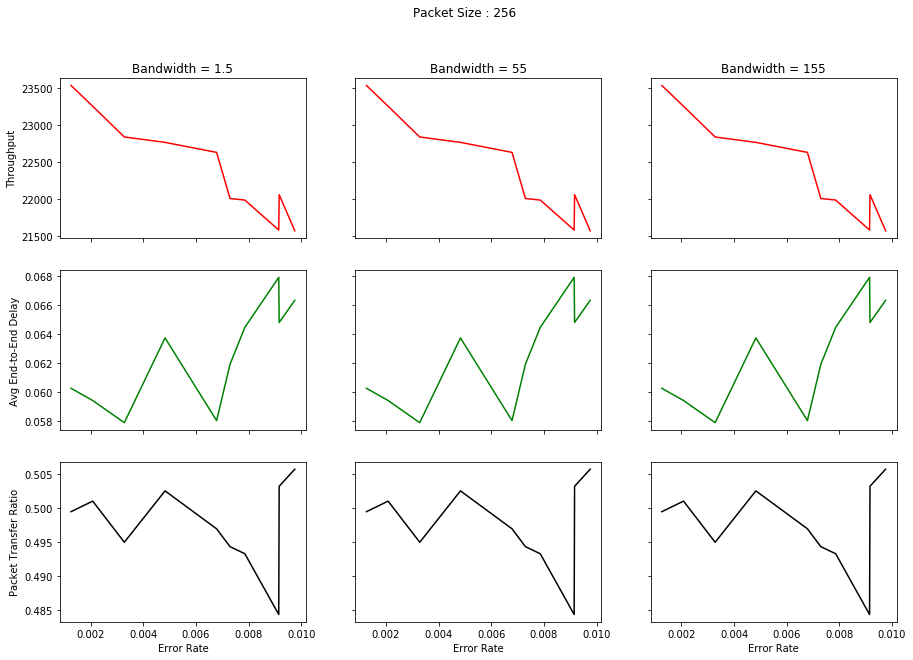

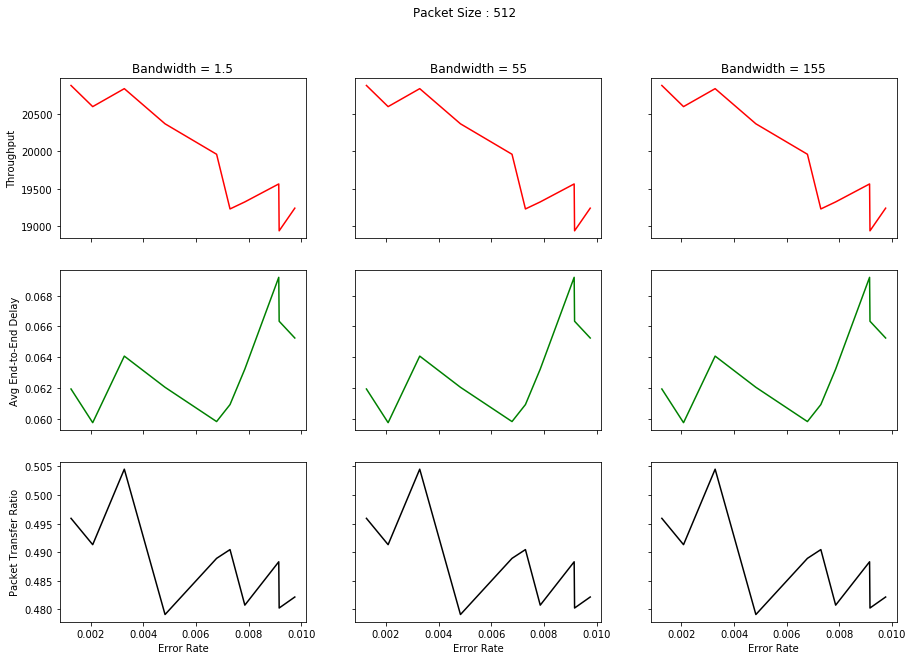

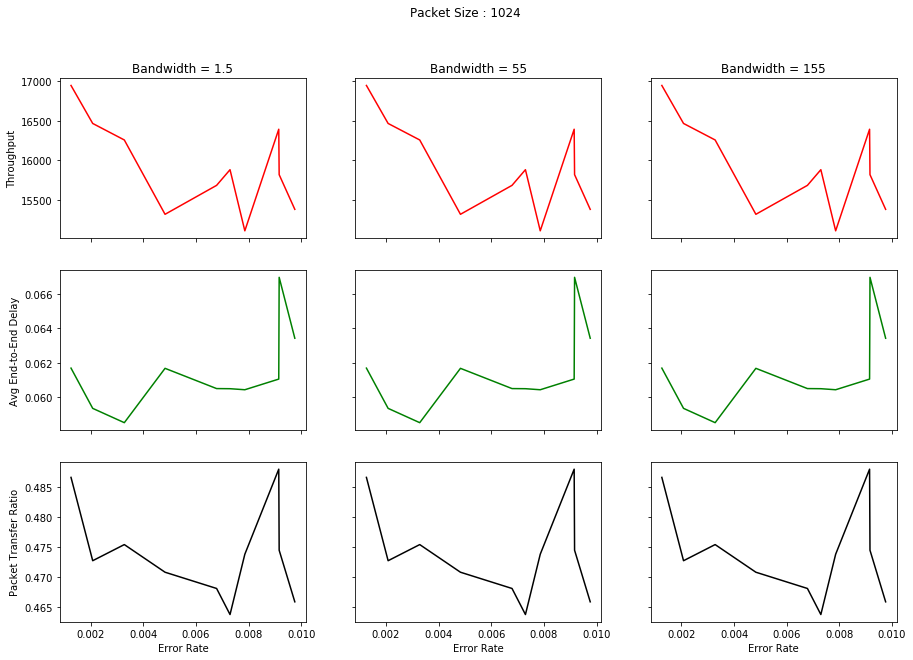

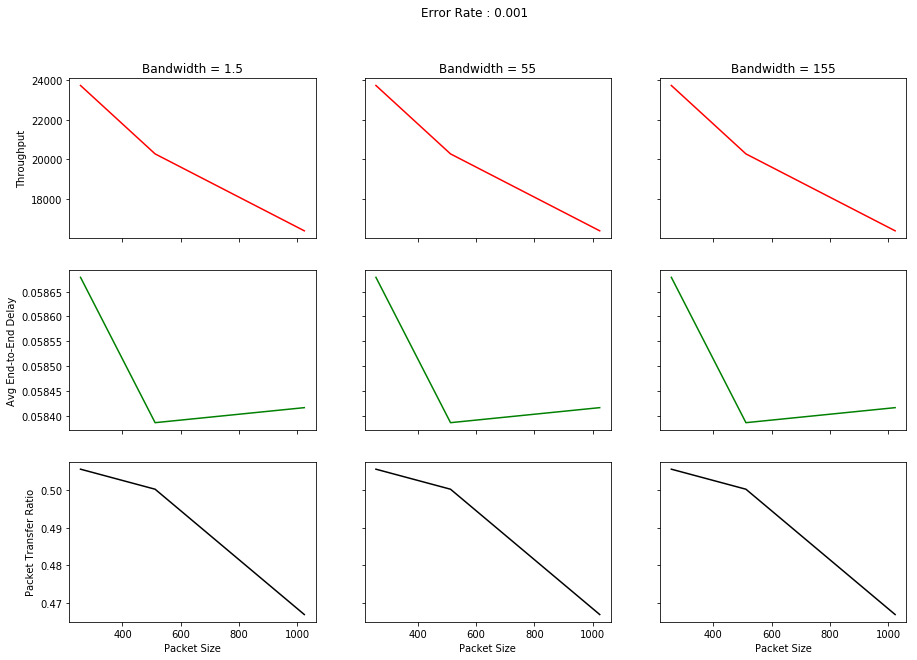

In [ ]:
packet_sizes = [256, 512, 1024]
bandwidths = [1.5, 55, 155]
error_rates = []

for i in range(10):
    error_rates.append(random.uniform(0.01, 0.001))
error_rates.sort()
        
for pktsz in packet_sizes:
    draw_plot_by_packet(bandwidths, error_rates, pktsz)
    
print("=========================================================================")

draw_plot_by_error_rate(bandwidths, 0.001, packet_sizes)